In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests
import matplotlib.pyplot as plt

In [2]:
DATA_HUB = dict()
DATA_URL = "https://d21-data.s3-accelerate.amazonaws.com/"

# Download from remote
# def download(name, cache_dir=os.path.join('..', 'data')):
#     assert name in DATA_HUB, f"{name} not in {DATA_HUB}."
#     url, sha1_hash = DATA_HUB[name]
#     os.makedirs(cache_dir, exist_ok=True)
#     fname = os.path.join(cache_dir, url.split('/')[-1])
#     if os.path.exists(fname):
#         sha1 = hashlib.sha1()
#         with open(fname, 'rb') as f:
#             while True:
#                 data = f.read(1048576)  # Read in 1MB chunks
#                 if not data:
#                     break
#                 sha1.update(data)
#         if sha1.hexdigest() == sha1_hash:
#             return fname  # File exists and the hash matches, return the file name
#     # If the execution reaches this point, the file either does not exist, or the hash does not match
#     print(f"Downloading {fname} from {url}...")
#     r = requests.get(url, stream=True, verify=True)
#     with open(fname, 'wb') as f:
#         for chunk in r.iter_content(chunk_size=1048576):
#             f.write(chunk)
#     print(f"Downloaded {fname}.")
#     return fname

def download(name, cache_dir='../house-prices-advanced-regression-techniques/'):
    assert name in DATA_HUB, f"{name} not in {DATA_HUB}."
    filepath, _ = DATA_HUB[name]
    # make sure the file exist
    if not os.path.exists(filepath):
        raise IOError(f"{filepath} does not exist.")
    return filepath

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# DATA_HUB[ 'kaggle_house_train'] = ( DATA_URL + 'kaggle_house_pred_train.csv', '585@9cc93e70b39160e7921475f9bcd7d31219ce')
# DATA_HUB[ 'kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv', 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

local_data_dir = 'house-prices-advanced-regression-techniques/'

DATA_HUB['kaggle_house_train'] = (local_data_dir + 'train.csv', 'sha1_of_train_file')
DATA_HUB['kaggle_house_test'] = (local_data_dir + 'test.csv', 'sha1_of_test_file')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download ('kaggle_house_test'))

print (train_data.shape) 
print (test_data.shape)

(1460, 81)
(1459, 80)


In [5]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [6]:
# remove id from data
all_features = pd. concat ((train_data.iloc[:,1:-1], test_data.iloc[:, 1:1]))

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index # find the numeric features
all_features[numeric_features] = all_features [numeric_features].apply(lambda x: (x - x.mean ()) / (x.std()) ) # Standardize the numeric features
all_features [numeric_features] = all_features[numeric_features].fillna(0) # Replace missing values with 0

In [7]:
# one hot encoding
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

In [8]:
n_train = train_data.shape[0]
all_features = all_features.astype(float)

# change to PyTorch tensor
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor (all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# Train

In [9]:
loss = nn.MSELoss() # Mean Squared Error Loss
in_features = train_features.shape[1] # Determine the number of input features

def get_net ():
    # The linear layer takes 'in_features' as input and outputs a single value (1)
    net = nn. Sequential(nn.Linear(in_features, 1))
    return net

In [10]:
# log: relative error
def log_rmse(net, features, labels) :
    clipped_preds = torch.clamp(net (features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse. item()

In [11]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_losses, test_losses = [], [] 
    train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_features, train_labels), batch_size=batch_size)  # use DataLoader to split data into small peices
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay) # choose Adam optimizer
    loss = nn.MSELoss()
    for epoch in range(num_epochs):
        for X, Y in train_iter:
            optimizer.zero_grad()  # set gradient to 0
            l = loss(net(X), Y)
            l.backward()
            optimizer.step()  # update
        train_losses.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_losses.append(log_rmse(net, test_features, test_labels))
    return train_losses, test_losses

In [12]:
# k-fold cross validation
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, Y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, Y_part
        elif X_train is None:
            X_train, y_train = X_part, Y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, Y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [13]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0.0, 0.0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)  # Assuming this function is defined elsewhere
        net = get_net()  # Assuming this function is defined elsewhere
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            # Plotting the learning curves for the first fold
            plt.plot(list(range(1, num_epochs + 1)), train_ls, label='Train')
            plt.plot(list(range(1, num_epochs + 1)), valid_ls, label='Valid', linestyle='dashed')
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.xlim([1, num_epochs])
            plt.yscale('log')
            plt.legend()
            plt.show()
        print(f'Fold {i + 1}, train log RMSE {float(train_ls[-1]):f}, valid log RMSE {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

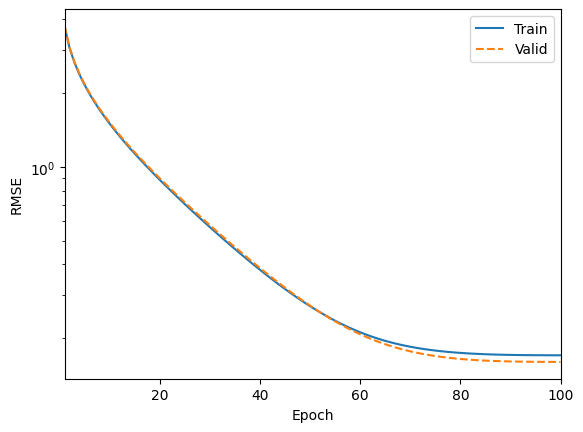

Fold 1, train log RMSE 0.169983, valid log RMSE 0.159702
Fold 2, train log RMSE 0.160983, valid log RMSE 0.185929
Fold 3, train log RMSE 0.163225, valid log RMSE 0.166144
Fold 4, train log RMSE 0.167226, valid log RMSE 0.153033
Fold 5, train log RMSE 0.161320, valid log RMSE 0.183877
5-fold validation: Average train log RMSE: 0.1645, Average valid log RMSE: 0.1697


In [14]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64 # tuned param
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: Average train log RMSE: {float(train_l):.4f}, Average valid log RMSE: {float(valid_l):.4f}')

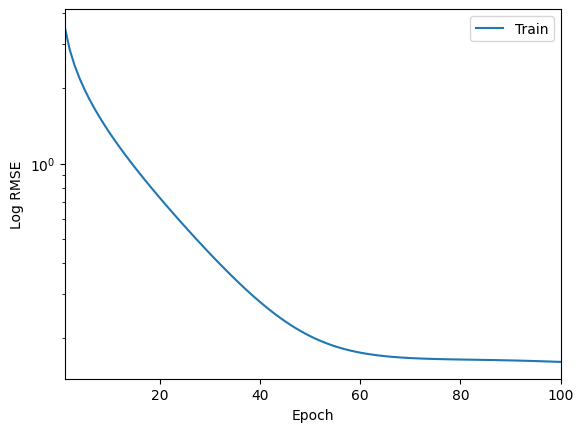

Train log RMSE: 0.160918


In [15]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    
    plt.plot(np.arange(1, num_epochs + 1), train_ls, label='Train')
    plt.xlabel('Epoch')  
    plt.ylabel('Log RMSE')
    plt.xlim([1, num_epochs])
    plt.yscale('log')
    plt.legend()
    plt.show()

    print(f'Train log RMSE: {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(-1))
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

# predict based on tune parameters
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)